In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats 
sns.set(style="whitegrid")


%matplotlib inline

<h1>Take Home Assigment : Listening Sessions</h1>

<h2>Dataset Description</h2>
<ul>                                                                                         
    <li>end_song_sample.csv</li>
    <ul>
        <li><b>ms_played</b> -- the amount of time the user listened to this track, in milliseconds         </li>
        <li><b>context</b> -- the UI context the track was played from (e.g. playlist or artist page)       </li>
        <li><b>track_id</b> -- the random UUID for the track                                                </li>
        <li><b>product</b> -- the product status (e.g. free or paid)                                        </li>
        <li><b>end_timestamp</b> -- the Epoch timestamp that marks the end of the listen                    </li>
        <li><b>user_id</b> -- the anonymous, random UUID of the user                                        </li>
    </ul>
    <li>user_data_sample.csv</li>
    <ul>
        <li><b>gender</b> -- the gender of the user (male or female)                                        </li>
        <li><b>age_range</b> -- a bucketed age of the user                                                  </li>
        <li><b>country</b> -- the country where the user registered                                         </li>
        <li><b>acct_age_weeks</b> -- the age of the user's account in weeks as of Oct 14th, 2015            </li>
        <li><b>user_id</b> -- the anonymous, random UUID of the user                                        </li>
    </ul>
</ul>

<h2>Read the data</h2>

In [2]:
users = pd.read_csv("user_data_sample.csv")
songs = pd.read_csv("end_song_sample.csv")
data = songs.merge(users, how='inner', on='user_id')

In [3]:
users.describe()

,acct_age_weeks
count,9565.000000
mean,74.094093
std,76.810872
min,-1.000000
25%,15.000000
50%,49.000000
75%,113.000000
max,363.000000


In [4]:
data.describe()

,ms_played,end_timestamp,acct_age_weeks
count,1.342891e+06,1.342891e+06,1.342891e+06
mean,1.287120e+05,1.444270e+09,7.936324e+01
std,1.200548e+05,3.518090e+05,7.656259e+01
min,0.000000e+00,1.443658e+09,-1.000000e+00
25%,3.778000e+03,1.443964e+09,1.900000e+01
50%,1.476780e+05,1.444272e+09,5.500000e+01
75%,2.228010e+05,1.444574e+09,1.210000e+02
max,5.100017e+06,1.444867e+09,3.630000e+02


First we describe the data. We notice that the account age min value is <b>-1</b> which is odd. I guess it means that the user just created his account and the age is <i><b>Less than a week</b></i>. 

To keep working with positive values, let's replace the '-1' by '0.5' which means pratically the same in that case : 'less than a week'

In [5]:
data.loc[data.acct_age_weeks == -1, 'acct_age_weeks'] = 0.5
data.describe()

,ms_played,end_timestamp,acct_age_weeks
count,1.342891e+06,1.342891e+06,1.342891e+06
mean,1.287120e+05,1.444270e+09,7.936609e+01
std,1.200548e+05,3.518090e+05,7.655962e+01
min,0.000000e+00,1.443658e+09,0.000000e+00
25%,3.778000e+03,1.443964e+09,1.900000e+01
50%,1.476780e+05,1.444272e+09,5.500000e+01
75%,2.228010e+05,1.444574e+09,1.210000e+02
max,5.100017e+06,1.444867e+09,3.630000e+02


Our negative problem is solved now!!

<h1>Define listening sessions</h1>

Let's first convert the Epoch timestamp into a more readable format.

In [6]:
import datetime

data['start_timestamp'] = (data['end_timestamp']*1000 - data['ms_played'])/1000.0

#Convert timestamps to date
data['start_date'] = data['start_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
                                                                                     
data['end_date'] = data['end_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
 

<h2>Exploration on a specific user</h2>

In [7]:
#Find the user with the mosts tracks listened
user_count_tracks = data.groupby(['user_id'], as_index=False).agg({'track_id':'count'})
user_count_tracks.columns = ['user_id', 'count_tracks']

user_count_tracks = user_count_tracks.sort_values("count_tracks", ascending=False)

max_tracks_listened = user_count_tracks.count_tracks.max()
user_star_id = user_count_tracks[user_count_tracks.count_tracks ==  max_tracks_listened]['user_id'].values[0]
print('The user id of the user with the most tracks listened is', user_star_id, 'and he has listened', max_tracks_listened, 'tracks')
user_count_tracks.head()

The user id of the user with the most tracks listened is 8d758d1cf1ae4a6aac3ada5576b4fc25 and he has listened 4409 tracks


,user_id,count_tracks
5280,8d758d1cf1ae4a6aac3ada5576b4fc25,4409
7788,d10c8673c24048edb5ab72cfdc803b34,3869
62,01d7789847e9489aaca7230b8cf7f145,3471
7638,cd21473103fc4fe987008baa2060fea0,3374
1552,289d885bb40f4d84b8499e879fa080a1,3308


We found our test subject. Now we are going to extract a <b>24 hours</b> sample of his listening and try to find some hints for a session definition.

In [8]:
data_star = data[data.user_id == user_star_id]
print(len(data_star),'Tracks on the dataframe before sample extract')

#We take a sample of the data (24 hours)
data_star = data_star[(data_star.start_date > '2015-10-12 00:00:00') & (data_star.start_date < '2015-10-14 00:00:00')]

print(len(data_star),'Tracks on the dataframe after sample extract')
data_star = data_star.sort('start_timestamp', ascending=True)
data_star.ms_played = data_star.ms_played/(1000*60)

4409 Tracks on the dataframe before sample extract
776 Tracks on the dataframe after sample extract


C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


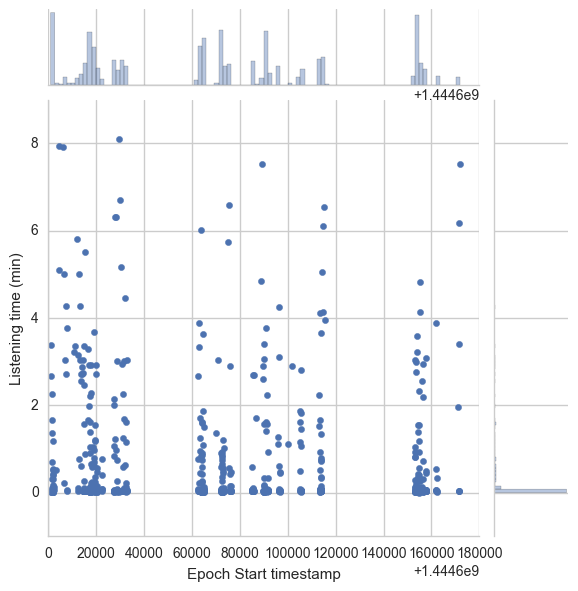

In [9]:
sns.jointplot(x="start_timestamp", y="ms_played", data=data_star,stat_func=None, marginal_kws=dict(bins=100, rug=False)).set_axis_labels("Epoch Start timestamp", "Listening time (min)")

For this user, we can see that we have a clear separation in the user listening repartitions. 
<img src="./session_breakdown.JPG">

The potentials sessions we see appears when the user spend some time without listening to a track, when the wait time between tracks is higher than usual and our eye catches dissimiliraty faster than normal events this is why I see them as listening session.

So let's use that hint to define what a session is. <b>A session is a period of time during which the wait time between two consecutives songs is not unusual</b>. If only i could give that sentence to my dataframe and get my sessions in return :'(. But no we have to give him something that it will understand, like what <b>unusual</b> means.

Well first let's compute the wait time and see what we have, maybe it'll help us see what's unusual.

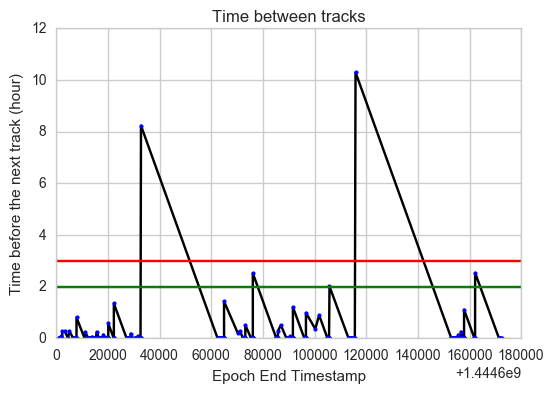

In [10]:
#Let's see the distribution of the time gap between two consecutives tracks

data_star['wait_time'] = np.zeros(len(data_star))

prev_row = None
for row in data_star.itertuples():
    if (prev_row != None) :
        wait_time = np.abs(row.start_timestamp - prev_row.end_timestamp)
        data_star.set_value(prev_row.Index, 'wait_time', wait_time)
        prev_row = row
    else :
        prev_row = row

data_star['wait_time'] = data_star['wait_time']/3600
plt.plot(data_star['end_timestamp'], data_star['wait_time'], '-', 
         marker='o',  markersize=3,  markerfacecolor='blue', color ='black')
plt.axhline(y=3, xmin=0, xmax=1, hold=None, color='r')
plt.axhline(y=2, xmin=0, xmax=1, hold=None, color='green')
plt.xlabel("Epoch End Timestamp")
plt.ylabel("Time before the next track (hour)")
plt.title("Time between tracks")


We can still see unusual events here. First, the two biggest peaks are very unusual (atleast for our sample). According to that, we can assume that there is 3 sessions in this graph separated by the big peaks. That means that the wait time treshold to pass from a session to another is atleast <b>3 hours</b> (red line)<br/> 
The two big peaks where the obvious one, there are others peaks which are not very common. Let's lower our treshold to <b>2 hours</b>. Two new peaks appears, with them we have <b>5</b> differents sessions. Nothing avoid us to go lower than that but we have to make a decision somewhere. So let's decide that for that sample the wait time treshold to pass from a session to another is 2 hours.

Well, we manage to define what a session is for one user (on more than 9000), on a 24 hour sample. As you would have guessed we are not going to do the same thing to define all the sessions for all  the users. We need to find a way to define a treshold based on unusual events.

Lucky us, there is a statistical indicator called <b>Z-Score (zscore = (value - mean)/std)</b> which allow us to find the outliers in a set of data. So instead of defining a treshold on the wait time, we are going to define one for the Z-Score.<br/>
Let's find the Z-Score corresponding to our 2 hour treshold we define earlier.

In [11]:
zscore = (2 - data_star.wait_time.mean())/data_star.wait_time.std()

print('The Z-Score for a wait time treshold of 2 hours is : {0:.2f}'.format(zscore))

The Z-Score for a wait time treshold of 2 hours is : 3.84


The Z-Score treshold to have a wait time treshold of 2 hours for our sample is <b>3.84</b>.<br/>
Let's round that and say we take our Z-Score for all users at <b>4</b>



In [12]:
zscore_th = 4

wait time treshold corresponding to a zscore_th of 4 : 2.080


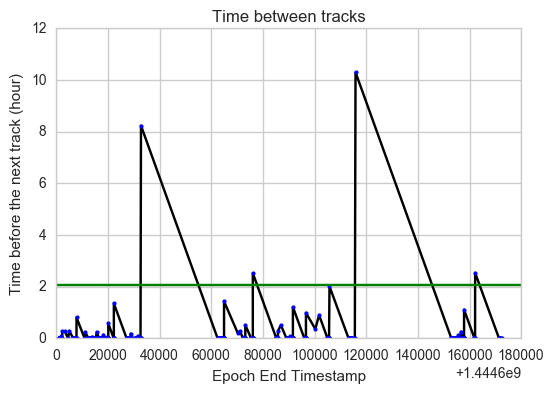

In [13]:
#For a zscore treshold at 4, let's see what's the wait time treshold on our sample
wait_time_th = zscore_th*data_star.wait_time.std() + data_star.wait_time.mean()
print('wait time treshold corresponding to a zscore_th of 4 : {0:.3f}'.format(wait_time_th))

plt.plot(data_star['end_timestamp'], data_star['wait_time'], '-', 
         marker='o',  markersize=3,  markerfacecolor='blue', color ='black')
plt.axhline(y=wait_time_th, xmin=0, xmax=1, hold=None, color='green')
plt.xlabel("Epoch End Timestamp")
plt.ylabel("Time before the next track (hour)")
plt.title("Time between tracks")

In [14]:
data_star['zscore'] = stats.zscore(data_star['wait_time'])

data_star['session_id'] = 0

current_session_id = 0

for row in data_star.itertuples() :
    data_star.set_value(row.Index ,'session_id', current_session_id)
    if (row.zscore > zscore_th) :
        current_session_id += 1

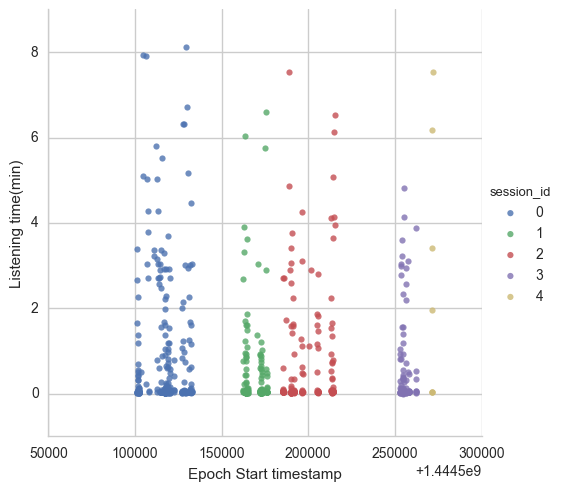

In [15]:
sns.lmplot("start_timestamp", "ms_played", data=data_star, hue='session_id', fit_reg=False)
plt.xlabel('Epoch Start timestamp')
plt.ylabel('Listening time(min)')

We managed to define what is a session and detect them for a specific user on a specific time period. Let's now apply this on the whole dataset.

<h2>Sessions for all</h2>

In [16]:
user_id_list = list(data.user_id.unique())

print('There is', len(user_id_list), 'unique users')

There is 9565 unique users


In [17]:
#Let's create the sessions dataframe
df_sessions = pd.DataFrame(columns=['session_id', 'user_id', 'start_timestamp','start_date', 'duration'])

In [18]:
#For every user let's compute all his sessions

data['session_id'] = -1

current_session_id = 0
for user_id in user_id_list :
    tracks_user = data[data.user_id == user_id]
    
    #Compute the wait_time
    tracks_user['wait_time'] = 0
    prev_row = None
    for row in tracks_user.itertuples():
        if (prev_row != None) :
            wait_time = np.abs(row.start_timestamp - prev_row.end_timestamp)
            tracks_user.set_value(prev_row.Index, 'wait_time', wait_time)
            prev_row = row
        else :
            prev_row = row
    
    #Compute the Z-Score
    tracks_user['zscore'] = stats.zscore(tracks_user['wait_time'])
    
    for row in tracks_user.itertuples() :
        data.set_value(row.Index ,'session_id', current_session_id)
        if (row.zscore > zscore_th) :
            current_session_id += 1
    
    e = user_id_list.index(user_id)
    if(e%100 == 0):
        print(e,'/', (len(user_id_list)-1))
    #When we finish with an user we increment the session_id        
    current_session_id += 1


C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\i327247\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 / 9564
100 / 9564
200 / 9564
300 / 9564
400 / 9564
500 / 9564
600 / 9564
700 / 9564
800 / 9564
900 / 9564
1000 / 9564
1100 / 9564
1200 / 9564
1300 / 9564
1400 / 9564
1500 / 9564
1600 / 9564
1700 / 9564
1800 / 9564
1900 / 9564
2000 / 9564
2100 / 9564
2200 / 9564
2300 / 9564
2400 / 9564
2500 / 9564
2600 / 9564
2700 / 9564
2800 / 9564
2900 / 9564
3000 / 9564
3100 / 9564
3200 / 9564
3300 / 9564
3400 / 9564
3500 / 9564
3600 / 9564
3700 / 9564
3800 / 9564
3900 / 9564
4000 / 9564
4100 / 9564
4200 / 9564
4300 / 9564
4400 / 9564
4500 / 9564
4600 / 9564
4700 / 9564
4800 / 9564
4900 / 9564
5000 / 9564
5100 / 9564
5200 / 9564
5300 / 9564
5400 / 9564
5500 / 9564
5600 / 9564
5700 / 9564
5800 / 9564
5900 / 9564
6000 / 9564
6100 / 9564
6200 / 9564
6300 / 9564
6400 / 9564
6500 / 9564
6600 / 9564
6700 / 9564
6800 / 9564
6900 / 9564
7000 / 9564
7100 / 9564
7200 / 9564
7300 / 9564
7400 / 9564
7500 / 9564
7600 / 9564
7700 / 9564
7800 / 9564
7900 / 9564
8000 / 9564
8100 / 9564
8200 / 9564
8300 / 9564
8400

In [19]:
data.to_csv('all_data_session_breakdown_zscore_4.csv')

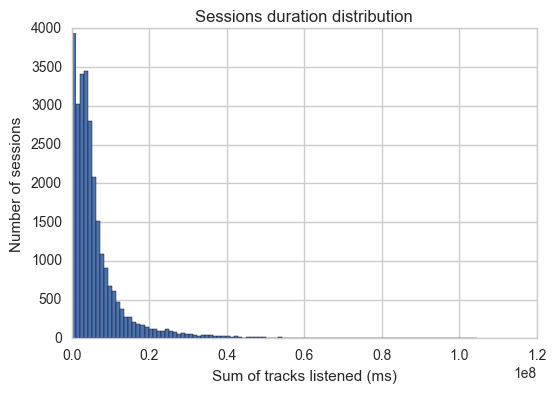

In [20]:
#Listening per session
sessions_duration = data.groupby(['session_id', 'gender'], as_index=False).agg({"ms_played":"sum"})
sessions_duration.columns = ['session_id', 'gender', 'sum_ms_played']

sessions_duration.sum_ms_played.hist(bins=100)
plt.xlabel('Sum of tracks listened (ms)')
plt.ylabel('Number of sessions')
plt.title('Sessions duration distribution')

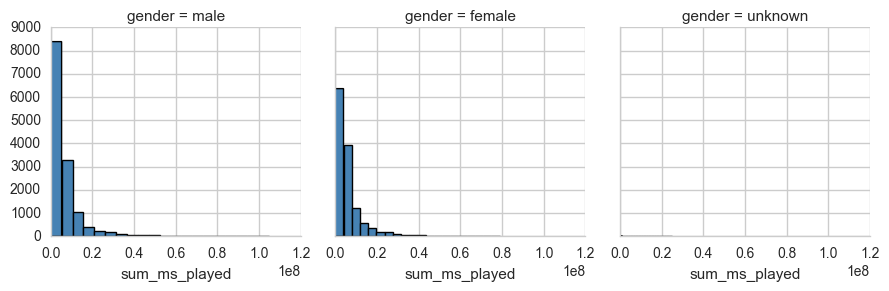

In [21]:
g = sns.FacetGrid(sessions_duration, col="gender", margin_titles=True)
bins = np.linspace(0, 1e8, 40)
g.map(plt.hist, "sum_ms_played", color="steelblue", bins=20, lw=1)